In [1]:
#!/usr/bin/python3
import math
import os
import sys
import numpy as np
from PIL import Image
from skimage.draw import random_shapes
from tqdm import tqdm_notebook as tqdm
import h5py
import cmath

###########################################################################################
# script to generate moving mnist video dataset (frame by frame) as described in
# [1] arXiv:1502.04681 - Unsupervised Learning of Video Representations Using LSTMs
#     Srivastava et al
# by Tencia Lee
# saves in hdf5, npz, or jpg (individual frames) format
###########################################################################################

# modification: saves labels frame-wise
# run as generate_moving_mnist.py --dest ./data --num_frames 20 --num_videos 10000

# helper functions

def arr_to_pilarr(img, mean=0, std=1):
    '''
    Args:
        img: image array of shape C x W x H
        mean: Mean to add
        std: Standard Deviation to add
    Returns:
        Image with dimensions H x W x C or H x W if it's a single channel image
    '''
    img_std = (((img + mean)*255.)*std).astype(np.uint8)
    img_std = img_std.clip(0, 255).transpose(2,1,0).squeeze()
    return img_std


# loads mnist from web on demand
def load_dataset():
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
    
    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    return X_train, y_train, X_val, y_val, X_test, y_test


def generate_moving_mnist(
    split="train",
    shape=(64, 64), 
    num_frames=30, 
    num_videos=100, 
    ignore_label=255,
#     mnist_size_randomize=False, # TODO 
# if mnist_size_randomize : .resize((original_size, original_size),Image.ANTIALIAS)
    min_nums_per_image=2, max_nums_per_image=2,
    rotatehint=False):
    '''
    Args:
        training: Boolean, used to decide if downloading/generating train set or test set
        shape: Shape we want for our moving images (new_width and new_height)
        num_frames: Number of frames in a particular movement/animation/gif
        num_videos: Number of movement/animations/gif to generate
        original_size: Real size of the images (eg: MNIST is 28x28)
        nums_per_image: Digits per movement/animation/gif. 
        If a list of possible nums_per_image is provided, the number is sampled randomly from the list per video
    Returns:
        Dataset of np.uint8 type with dimensions num_videos x num_frames x 1 x new_width x new_height
    '''
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset() 
    
    if "train" in split:
        mnist = X_train
        mnist_lab = y_train
    elif "val" in split:
        mnist = X_val
        mnist_lab = y_val
    elif "test" in split:
        mnist = X_test
        mnist_lab = y_test
    else:
        raise ValueError("allowed values for 'split' are ['train','test','val'] but given {}".format(split))
    
    height, width = shape
    n, _, mnist_height, mnist_width = X_test.shape
    assert min_nums_per_image<=max_nums_per_image
    # Get how many pixels can we move around a single image
    lims = (x_lim, y_lim) = width - mnist_width, height - mnist_height
    
    # Create a dataset of shape of num_videos X num_frames x 1 x new_width x new_height Eg : 20000 x 20 x 1 x 64 x 64
    dataset = np.empty((num_videos, num_frames, 1, height, width), dtype=np.uint8)
    dataset_masks = np.empty((num_videos, num_frames, 1, height, width), dtype=np.uint8)
    dataset_labels = np.empty((num_videos, num_frames,  max_nums_per_image, 3), dtype=np.float)

    for vid_idx in tqdm(range(num_videos)):
        # randomly select the number of nums per image
        nums_per_image = np.random.randint(min_nums_per_image, max_nums_per_image+1)
        if nums_per_image:
            # Randomly generate velocity (direction + speed), 
            max_speed = 5
            speeds = np.random.randint(1, max_speed+1, size=nums_per_image)
            # choose one of the 8 directions to move
            total_dirs = 8 
            dir_vals = np.random.choice(np.arange(0,1,step=1/total_dirs), size=nums_per_image)
            # change direction values to range [-pi,+pi]
            direcs = np.pi*((dir_vals)*2 - 1)

#             print("Speed={}, Direc={}".format(speeds, dir_vals*total_dirs))
            veloc = np.asarray(
                [(speed*math.cos(direc), speed*math.sin(direc)) for direc, speed in zip(direcs, speeds)]
            )
            # Randomly generate brightness for all images
    #         rand_brightness = []
    #         for i in range(nums_per_image):
    #             start = np.random.uniform(0.1, 1.5)
    #             stop = np.random.uniform(0.1, 1.5) 
    #             step = (stop-start)/num_frames
    #             rand_brightness.append(np.arange(start, stop, step))

            # Get a list of MNIST images randomly sampled from the dataset
            rand_idx = np.random.randint(0, mnist.shape[0], nums_per_image)
            mnist_images = [Image.fromarray(arr_to_pilarr(mnist[s])) for s in rand_idx]
            mnist_labels = [mnist_lab[s] for s in rand_idx]
        
        # prepare a canvas with random shapes for each video
#         canvas_x_lims, canvas_y_lims = 20,20 
        canvas_x_lims, canvas_y_lims = 0,0 # dont move bg
        static_canvas_distractors,_ = random_shapes((height+canvas_x_lims, width+canvas_y_lims), 
                                                    min_shapes=15, max_shapes=25, 
                                                    multichannel=False, allow_overlap=True) 
#         canvas_position = np.random.randint(0, high=canvas_x_lims//2, size=(2,))
        
        if nums_per_image:
            # Generate initial positions for nums_per_image as tuples (x,y)
            positions = np.asarray(
                [(np.random.rand() * x_lim, np.random.rand() * y_lim) for _ in range(nums_per_image)]
            )
            # Generate initial rotation angle for nums_per_image
            rotates = np.random.randint(0, 360, size=nums_per_image)
            if rotatehint:
                rotate_increments = np.array(mnist_labels, dtype=int)*2
            else:
                rotate_increments = np.random.randint(0, 10, size=nums_per_image)
        
        # Generate new frames for the entire num_frames
        for frame_idx in range(num_frames): 
            labels_and_pos = []
            canvas = static_canvas_distractors.copy() #np.zeros((width, height), dtype=np.float32)#
            # move the bg canvas a little, if possible
#             if canvas_position[0]+2 < canvas_x_lims:
#                 canvas_position[0] = canvas_position[0] + np.random.randint(0,3)
#             if canvas_position[1]+2 < canvas_y_lims:
#                 canvas_position[1] = canvas_position[1] + np.random.randint(0,3)                
#             canvas = canvas[
#                 canvas_position[0]:canvas_position[0]+height, canvas_position[1]:canvas_position[1]+width
#             ]
            canvas[canvas==255] = 0
            canvas_mask = np.full((height, width), fill_value=ignore_label, dtype=np.float32)
            
            # Super impose images on the canvas
            for i in range(nums_per_image):
                # generate random noise for the canvas background
#                 noise = (np.random.normal(loc=127, scale=127, size=(height, width))).astype(np.uint8)
#                 canvas[canvas==0] = noise[canvas==0]
                canvas = canvas.astype(np.float32)
                # copy the MNIST image
                mnist_rotated = mnist_images[i] #.rotate(rotates[i].astype(int))
                mnist_copy = Image.new('L', (height, width))
                mnist_copy.paste(mnist_rotated, tuple(positions[i].astype(int)))
                mnist_copy = np.array(mnist_copy)#*rand_brightness[i][frame_idx]
                canvas[mnist_copy>0]=mnist_copy[mnist_copy>0]
                
                # if there are regions of overlap in canvas_mask, override with the last label
                canvas_mask[mnist_copy>0] = mnist_labels[i]
                
            # Get the next position by adding velocity
            next_pos = positions + veloc
            
            rotates = (rotates + rotate_increments)%360
            # Iterate over velocity and see if we hit the wall. If yes, change direction
            for i, pos in enumerate(next_pos):
                for j, coord in enumerate(pos):
                    if coord < 0 or coord > lims[j] :
                        veloc[i] = list(list(veloc[i][:j]) + [-1 * veloc[i][j]] + list(veloc[i][j + 1:]))
            # Make the permanent change to position by adding updated velocity
            positions = positions + veloc
            
            # labels calculations
            lbl_n_pos = []
            for i in range(nums_per_image):
                mag, angle = cmath.polar(complex(*veloc[i]))
                mag = round(mag/max_speed,2)
                # make angle in the range [0,1]
                angle = (angle/(math.pi) + 1)/2 
                angle_class = round(total_dirs*angle)
                if angle_class == total_dirs : angle_class=0
                lbl_n_pos.append([mnist_labels[i], mag, angle_class])
            
            labels_and_pos.append(lbl_n_pos)
            
            # Add the canvas to the dataset array
            dataset[vid_idx, frame_idx, 0] = canvas.clip(0, 255).astype(np.uint8) 
            dataset_masks[vid_idx, frame_idx, 0] = (canvas_mask).astype(np.uint8)  
            # Add the label to the dataset labels array
            dataset_labels[vid_idx, frame_idx, :nums_per_image] = np.array(labels_and_pos)
            
    return dataset, dataset_masks, dataset_labels

In [2]:
frame_size= 64
num_frames= 20  # length of each sequence
mnist_size_randomize = False  # to randomize the size of mnist digit within frame
min_nums_per_image = 1  # number of digits in each frame
max_nums_per_image = 1  # number of digits in each frame
ignore_label = 10
rotatehint = False
split, num_videos = ('train',10000)#('train',10000)#

In [3]:
dat, dat_masks, dat_labels = generate_moving_mnist(split, shape=(frame_size, frame_size),
                                        ignore_label=ignore_label,
                                        num_frames=num_frames, num_videos=num_videos,
                                        min_nums_per_image=min_nums_per_image, max_nums_per_image=max_nums_per_image,
                                        rotatehint=rotatehint)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:127: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [4]:
# np.unique(dat_labels[:,:,:,-1])

In [5]:
path = "./data"
suffix="1ss"
filetype = "npy"


if not os.path.isdir(path):
    print("creating folder ", path)
    os.makedirs(path)
    
# save images and labels
#np.save(path+split+"_images", dat)
np.save("{}/data{}".format(path, suffix), dat)
np.save("{}/data{}_labels".format(path, suffix), dat_labels)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

dat = np.load("{}/data{}.npy".format(path, suffix))
dat_labels = np.load("{}/data{}_labels.npy".format(path, suffix))

print(dat.shape, dat_labels.shape)

(10000, 20, 1, 64, 64) (10000, 20, 1, 3)


/usr/local/lib/python3.5/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


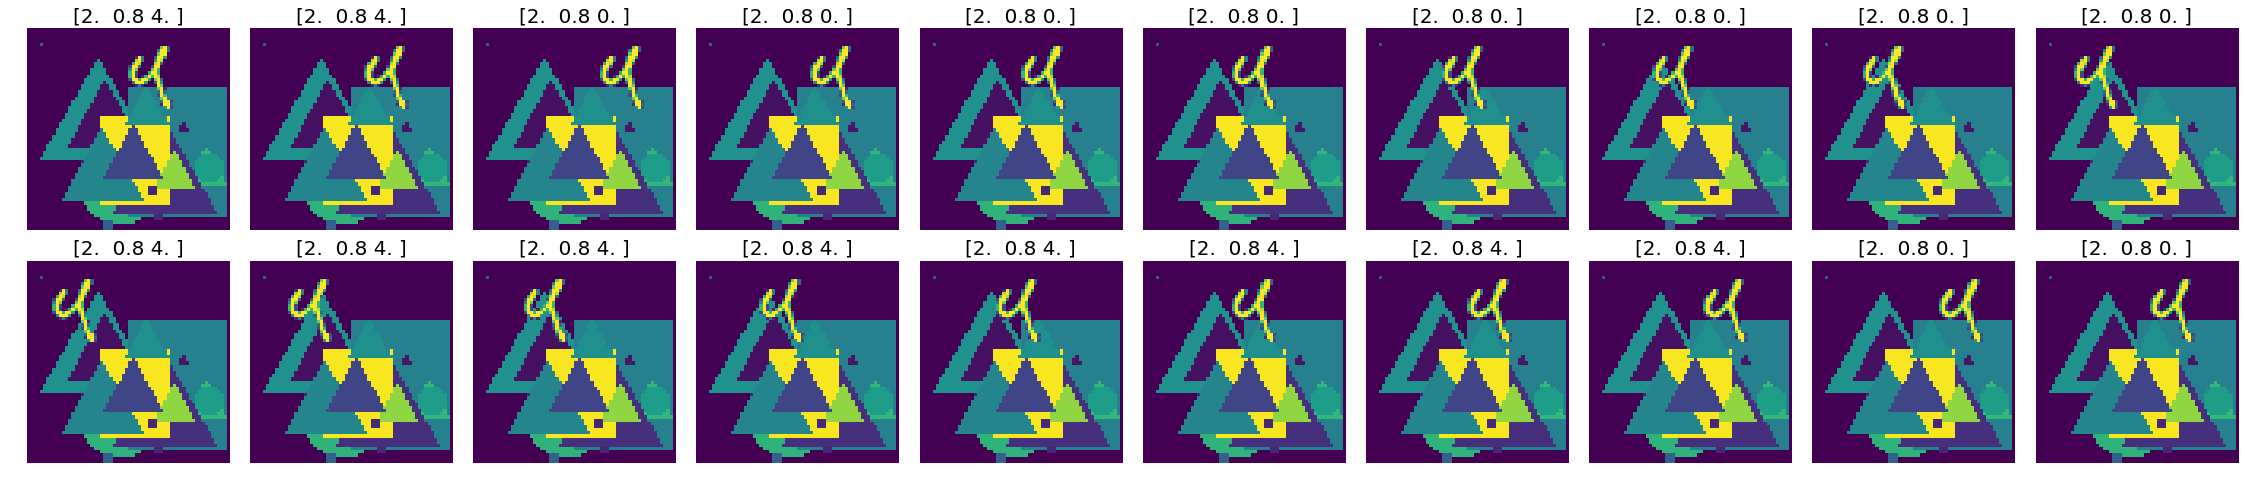

In [7]:
plot_vid = np.random.randint(0, num_videos)
num_frames = 20 if num_frames>20 else num_frames

fig, axes = plt.subplots(nrows=2, ncols=num_frames//2, figsize=(2*num_frames,8))

for i, ax in enumerate(axes.reshape(-1)):
    ax.axis('off')
    ax.imshow(dat[plot_vid,i,0])
    ax.set_title(dat_labels[plot_vid,i,0], fontdict = {'fontsize' : 400//num_frames})
#     plt.subplot(2, num_frames, num_frames+i+1).axis('off')
#     plt.imshow((dat_masks[plot_vid,i][0,:,:]+1)*20)
plt.subplots_adjust(wspace=0., hspace=0.15)
plt.show()